In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt

import torch
print(torch.__version__)
import torchvision
from torchvision import datasets, transforms

import helper

0.4.1


In [2]:
data_dir = '/home/akshay/Projects/flower_classification/flowers/train'
batch_size = 32
tf = transforms.Compose([transforms.Resize((255, 255)),
                         transforms.ToTensor(),
                        ])

train_dataset = datasets.ImageFolder(data_dir, transform = tf)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = batch_size, shuffle = True)

data_dir = '/home/akshay/Projects/flower_classification/flowers/test'

test_dataset = datasets.ImageFolder(data_dir, transform = tf)

test_loader = torch.utils.data.DataLoader(test_dataset, batch_size = batch_size, shuffle = True)

torch.Size([32, 3, 255, 255])
torch.Size([32])


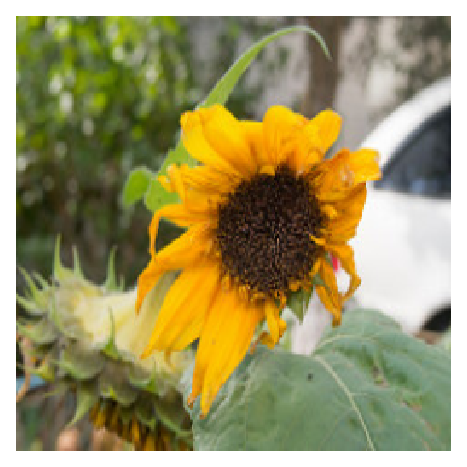

In [4]:
images, labels = next(iter(test_loader))
print(images.shape)
helper.imshow(images[0], normalize = False)
print(labels.shape)

In [4]:
a = images.view(images.shape[0], -1)
print(a.shape)

torch.Size([32, 195075])


In [5]:
m = len(train_loader) * batch_size
n = 255 * 255 * 3
learning_rate = 1e-3
W = torch.randn(n, 1).float()
b = torch.randn(1, 1).float()

In [6]:
def binary_cross_entropy(A, Y):
    loss = -(1 / m) * (torch.dot(Y, A) + torch.dot((1 - Y), (1 - A)))
    return loss

In [7]:
def sigmoid(x):
    return (1 / (1 + torch.exp(-x)))

In [8]:
def forward(x):
    out = torch.matmul(W.t(), x) + b
    out = sigmoid(out)
    # size - (1, batch_size)
    return out

In [23]:
# Training Loop
for i in range(20):
    epoch_loss = 0
    for batch_idx, (images, labels) in enumerate(train_loader):
        if torch.cuda.is_available():
            images = images.cuda()
            labels = labels.cuda()
            W = W.cuda()
            b = b.cuda()
        labels = labels.float()
        images = images.view(-1, images.shape[0]).float()
#         print(images.shape)
#         print(W.shape)
#         print('Images and labels modified as required')
        pred = forward(images)
#         print('Forward propagation done')
#         _, index_pred = torch.max(pred, 0)
        
        loss = binary_cross_entropy(pred.resize_(pred.shape[1]), labels)
        epoch_loss += loss.item()
#         print('Current loss calculated')
        dz = pred - labels.resize_(labels.shape[0])
#         print(dz.shape)
#         print(images.shape)
        dw = (1 / m) * torch.matmul(dz, images.t())
#         print(dw.shape)
        db = (1 / m) * torch.sum(dz)
#         print(db.shape)
#         print('back prop done')
        dw2 = learning_rate * dw
#         print(dw2.shape)
#         print(W.shape)
        W -= dw2.resize_(dw2.shape[0], 1)
        b -= (learning_rate * db)
#         print('Loss at step ', batch_idx, ' = ', epoch_loss)

    epoch_loss /= m
    print('Loss at epoch', i, ' = ', epoch_loss)
    
    acc = 0
    for batch_idx, (images, labels) in enumerate(test_loader):
        if torch.cuda.is_available():
            images = images.cuda()
            labels = labels.cuda()
            W = W.cuda()
            b = b.cuda()
        labels = labels.float()
        images = images.view(-1, images.shape[0]).float()
        
        pred = forward(images)
        pred = (pred >= 0.5).float()
        
        mismatch = torch.abs(pred - labels.resize_(labels.shape[0]))
        acc += torch.sum(mismatch)
        
    acc /= (len(test_loader) * batch_size)
    print('Validation accuracy at epoch ', i, ' = ', acc.item() * 100)

Loss at epoch 0  =  -0.00033931921412162905
Test accuracy at epoch  0  =  53.125
Loss at epoch 1  =  -0.00034835581622742626
Test accuracy at epoch  1  =  54.6875
Loss at epoch 2  =  -0.00034898630871215244
Test accuracy at epoch  2  =  48.4375
Loss at epoch 3  =  -0.00034488817155678674
Test accuracy at epoch  3  =  45.3125
Loss at epoch 4  =  -0.00036983347275633025
Test accuracy at epoch  4  =  53.125
Loss at epoch 5  =  -0.000347473896412835
Test accuracy at epoch  5  =  42.1875
Loss at epoch 6  =  -0.00035748933971097523
Test accuracy at epoch  6  =  51.5625
Loss at epoch 7  =  -0.00033290098905457523
Test accuracy at epoch  7  =  50.0
Loss at epoch 8  =  -0.0003545816090825776
Test accuracy at epoch  8  =  57.8125
Loss at epoch 9  =  -0.00035535756118902515
Test accuracy at epoch  9  =  36.71875
Loss at epoch 10  =  -0.0003533343935321847
Test accuracy at epoch  10  =  46.09375
Loss at epoch 11  =  -0.0003301508880791847
Test accuracy at epoch  11  =  35.9375
Loss at epoch 12  = 

In [16]:
a = torch.randn((2, 3))
print(a)

tensor([[-2.7275,  1.4247, -1.2109],
        [-0.0464, -1.5581,  0.5735]])


In [125]:
b = torch.transpose(a, 1, 0)
print(b)

tensor([[ 1.0537,  1.7875],
        [-0.1413,  0.5772],
        [-1.7341, -0.5618]])


In [17]:
a = a > 0.5
print(a)

tensor([[0, 1, 0],
        [0, 0, 1]], dtype=torch.uint8)


In [20]:
print(len(train_loader) * batch_size)

1408
